In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn 
import networkx as nx
from sklearn.datasets import make_moons
import torch
from torch import nn

# Optimal Transport 

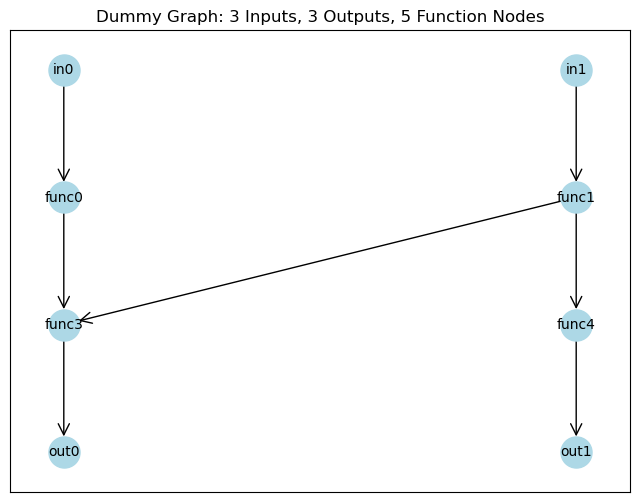

In [2]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4']
output_nodes = ['out0', 'out1']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0'), ('in1', 'func1')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3'), ('func1', 'func4'), ('func1', 'func3')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0'), ('func4', 'out1')])

# Define positions for each node for plotting
pos = {
    'in0': (-1, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-1, 1), 'func1': (0, 1), 'func2': (1, 1),
    'func3': (-1, 0), 'func4': (0, 0),
    'out0': (-1, -1), 'out1': (0, -1), 'out2': (2, -1)
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

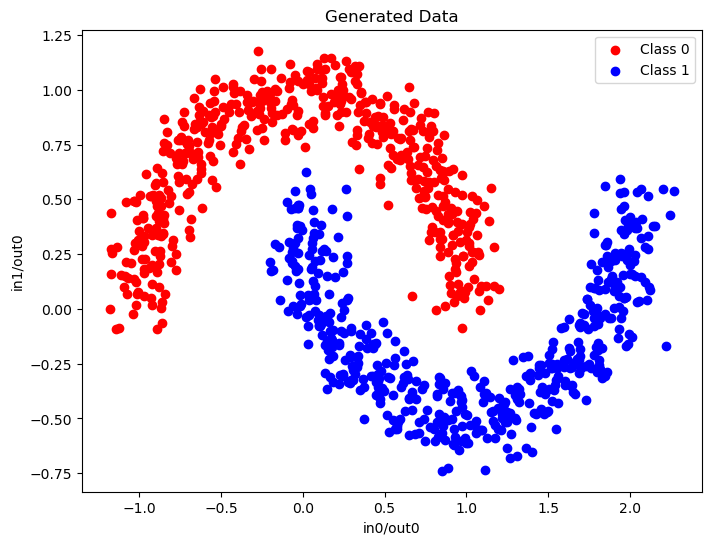

In [3]:
X,y = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

plt.figure(figsize=(8, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='Class 1')
plt.xlabel('in0/out0')
plt.ylabel('in1/out0')
plt.title('Generated Data')
plt.legend()
plt.show()

In [4]:
#https://github.com/atong01/ot-icnn-minimal/blob/main/icnn/icnn.py

class ICNN(torch.nn.Module):
    """Input Convex Neural Network"""
    #https://github.com/atong01/ot-icnn-minimal/blob/main/icnn/icnn.py

    def __init__(self, dim=2, dimh=64, num_hidden_layers=4):
        super().__init__()

        Wzs = []
        Wzs.append(nn.Linear(dim, dimh))
        for _ in range(num_hidden_layers - 1):
            Wzs.append(torch.nn.Linear(dimh, dimh, bias=False))
        Wzs.append(torch.nn.Linear(dimh, 1, bias=False))
        self.Wzs = torch.nn.ModuleList(Wzs)

        Wxs = []
        for _ in range(num_hidden_layers - 1):
            Wxs.append(nn.Linear(dim, dimh))
        Wxs.append(nn.Linear(dim, 1, bias=False))
        self.Wxs = torch.nn.ModuleList(Wxs)
        self.act = nn.Softplus()

    def forward(self, x):
        z = self.act(self.Wzs[0](x))
        for Wz, Wx in zip(self.Wzs[1:-1], self.Wxs[:-1]):
            z = self.act(Wz(z) + Wx(x))
        return self.Wzs[-1](z) + self.Wxs[-1](x)

def compute_w2(f, g, x, y, return_loss=False):
    fx = f(x)
    gy = g(y)

    grad_gy = torch.autograd.grad(torch.sum(gy), y, retain_graph=True, create_graph=True)[0]

    f_grad_gy = f(grad_gy)
    y_dot_grad_gy = torch.sum(torch.multiply(y, grad_gy), axis=1, keepdim=True)

    x_squared = torch.sum(torch.pow(x, 2), axis=1, keepdim=True)
    y_squared = torch.sum(torch.pow(y, 2), axis=1, keepdim=True)

    w2 = torch.mean(f_grad_gy - fx - y_dot_grad_gy + 0.5 * x_squared + 0.5 * y_squared)
    if not return_loss:
        return w2
    g_loss = torch.mean(f_grad_gy - y_dot_grad_gy)
    f_loss = torch.mean(fx - f_grad_gy)
    return w2, f_loss, g_loss

def transport(model, x):
    x = x.detach().requires_grad_(True)
    return torch.autograd.grad(torch.sum(model(x)), x)[0]

def to_torch(arr, device="cpu"):
    return torch.tensor(arr, device=device, requires_grad=True)


def train(f, g, x, y, batchsize=1024, reg=0, nepochs=1000, lr=1e-4):

    optimizer_f = torch.optim.Adam(f.parameters(), lr=lr, betas=(0.5, 0.9))
    optimizer_g = torch.optim.Adam(g.parameters(), lr=lr, betas=(0.5, 0.9))

    for epoch in range(1, nepochs + 1):
        for _ in range(10):
            optimizer_g.zero_grad()
            x = x[torch.randperm(x.size(0))[:batchsize]].detach()
            y = y[torch.randperm(y.size(0))[:batchsize]].detach()
            x.requires_grad = True; y.requires_grad = True
            fx = f(x)
            gy = g(y)
            grad_gy = torch.autograd.grad(
                torch.sum(gy), y, retain_graph=True, create_graph=True
            )[0]
            f_grad_gy = f(grad_gy)
            y_dot_grad_gy = torch.sum(torch.mul(y, grad_gy), axis=1, keepdim=True)
            g_loss = torch.mean(f_grad_gy - y_dot_grad_gy)
            if reg > 0:
                g_loss += reg * torch.sum(
                    torch.stack([torch.sum(torch.nn.functional.relu(-w.weight) ** 2) / 2 for w in g.Wzs])
                )
            g_loss.backward()
            optimizer_g.step()

        optimizer_f.zero_grad()
        x = x[torch.randperm(x.size(0))[:batchsize]].detach()
        y = y[torch.randperm(y.size(0))[:batchsize]].detach()
        x.requires_grad = True; y.requires_grad = True
        fx = f(x)
        gy = g(y)
        grad_gy = torch.autograd.grad(torch.sum(gy), y, retain_graph=True, create_graph=True)[
            0
        ]
        f_grad_gy = f(grad_gy)
        f_loss = torch.mean(fx - f_grad_gy)
        if reg > 0:
            f_loss += reg * torch.sum(
                torch.stack([torch.sum(torch.nn.functional.relu(-w.weight) ** 2) / 2 for w in f.Wzs])
            )

        f_loss.backward()
        optimizer_f.step()

        print(f'Epoch {epoch}: F loss {f_loss.item():.4f}, G loss {g_loss.item():.4f}', end='\r')

In [5]:
F = ICNN(2, 64)
G = ICNN(2, 64)

X_P = torch.tensor(X[y==0], dtype=torch.float32)
X_Q = torch.tensor(X[y==1], dtype=torch.float32)

train(F, G, X_P, X_Q, batchsize=500, reg=0, nepochs=5000, lr=1e-3)

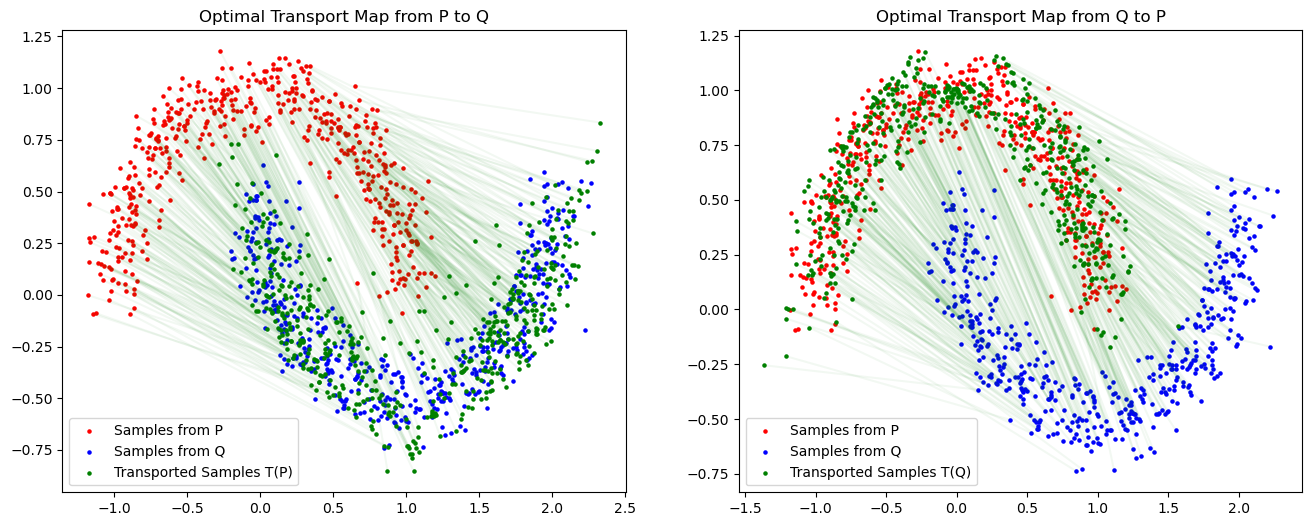

In [6]:
T_X_P = transport(F, X_P)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Optimal Transport Map from P to Q
axes[0].scatter(X_P[:, 0], X_P[:, 1], c='red', s=5, label='Samples from P')
axes[0].scatter(X_Q[:, 0], X_Q[:, 1], c='blue', s=5, label='Samples from Q')
axes[0].scatter(T_X_P[:, 0].detach(), T_X_P[:, 1].detach(), c='green', s=5, label='Transported Samples T(P)')

# Add green lines from X_P to T_X_P
for i in range(X_P.shape[0]):
    axes[0].plot([X_P[i, 0], T_X_P[i, 0].detach()], [X_P[i, 1], T_X_P[i, 1].detach()], 'g-', alpha=0.05)

axes[0].legend()
axes[0].set_title('Optimal Transport Map from P to Q')

T_X_Q = transport(G, X_Q)

# Plot for Optimal Transport Map from Q to P
axes[1].scatter(X_P[:, 0], X_P[:, 1], c='red', s=5, label='Samples from P')
axes[1].scatter(X_Q[:, 0], X_Q[:, 1], c='blue', s=5, label='Samples from Q')
axes[1].scatter(T_X_Q[:, 0].detach(), T_X_Q[:, 1].detach(), c='green', s=5, label='Transported Samples T(Q)')

# Add green lines from X_Q to T_X_Q
for i in range(X_Q.shape[0]):
    axes[1].plot([X_Q[i, 0], T_X_Q[i, 0].detach()], [X_Q[i, 1], T_X_Q[i, 1].detach()], 'g-', alpha=0.05)

axes[1].legend()
axes[1].set_title('Optimal Transport Map from Q to P')

plt.show()

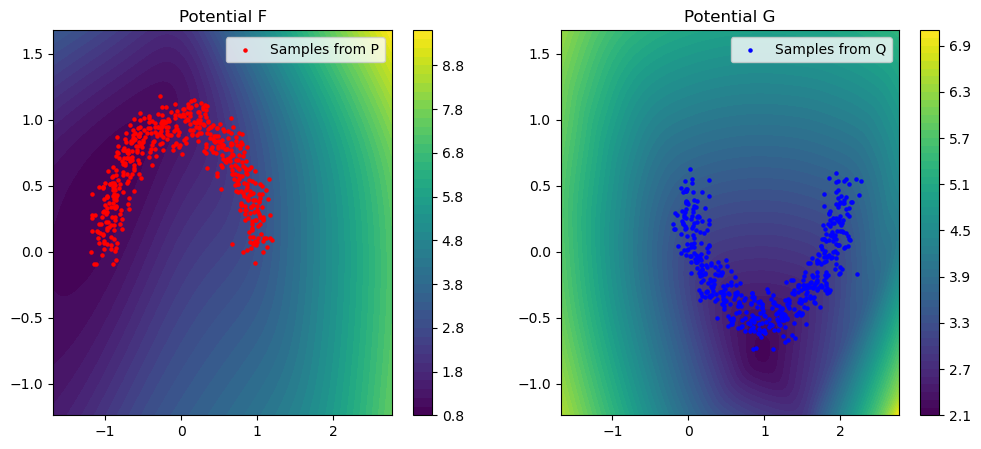

In [7]:
# Create a grid over the data range
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# Compute potentials over the grid
with torch.no_grad():
    F_vals = F(grid_points).reshape(xx.shape)
    G_vals = G(grid_points).reshape(xx.shape)

# Plot Potential F
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(xx, yy, F_vals.numpy(), levels=50, cmap='viridis')
plt.colorbar()
plt.title('Potential F')
plt.scatter(X_P[:, 0], X_P[:, 1], c='red', s=5, label='Samples from P')
plt.legend()

# Plot Potential G
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, G_vals.numpy(), levels=50, cmap='viridis')
plt.colorbar()
plt.title('Potential G')
plt.scatter(X_Q[:, 0], X_Q[:, 1], c='blue', s=5, label='Samples from Q')
plt.legend()

plt.show()

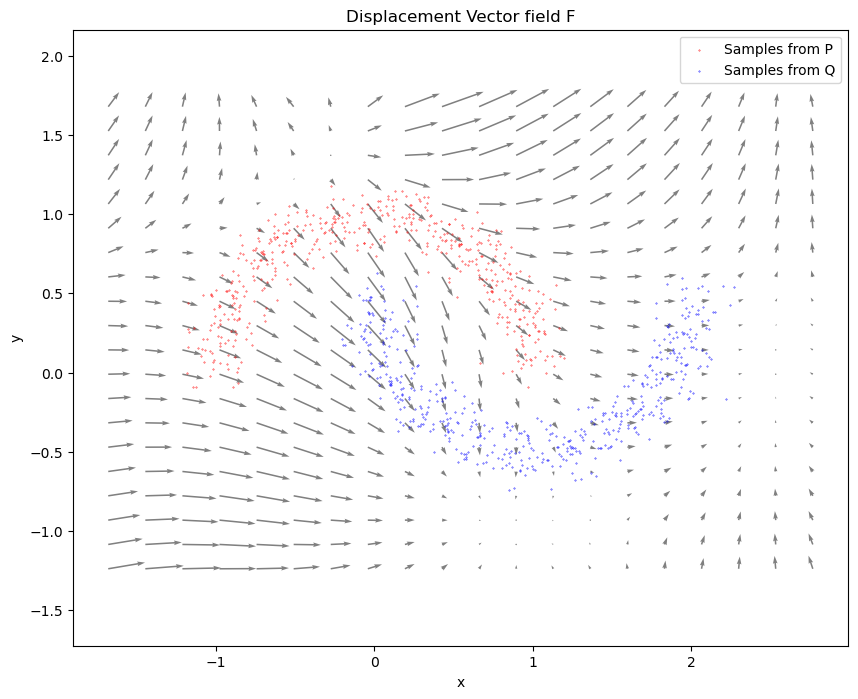

In [16]:
# Define the grid resolution
grid_size = 20  # Adjust for higher resolution

# Get the data range
x_min, x_max = X[:, 0].min().item() - 0.5, X[:, 0].max().item() + 0.5
y_min, y_max = X[:, 1].min().item() - 0.5, X[:, 1].max().item() + 0.5

# Create the grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                     np.linspace(y_min, y_max, grid_size))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

def compute_grid_gradients(F_net, G_net, grid_points):
    # Enable gradient computation
    grid_points = grid_points.clone().detach().requires_grad_(True)
    
    # Compute F at grid points
    F_values = F_net(grid_points)
    G_values = G_net(grid_points)
    
    # Compute gradients
    gradients = torch.autograd.grad(F_values.sum(), grid_points)[0]
    #gradients = torch.autograd.grad(G_values.sum(), grid_points)[0]
    
    return gradients.detach()

gradients = compute_grid_gradients(F, G, grid_points)

gradients = -(grid_points - gradients)

# Reshape gradients and grid points
U = gradients[:, 0].numpy().reshape(xx.shape)
V = gradients[:, 1].numpy().reshape(yy.shape)

X_grid = grid_points[:, 0].numpy().reshape(xx.shape)
Y_grid = grid_points[:, 1].numpy().reshape(yy.shape)

plt.figure(figsize=(10, 8))
plt.quiver(X_grid, Y_grid, U, V, color='gray', angles='xy', scale_units='xy', scale=10, width=0.002)

# Plot the original data points
plt.scatter(X_P[:, 0], X_P[:, 1], c='red', s=0.1, label='Samples from P')
plt.scatter(X_Q[:, 0], X_Q[:, 1], c='blue', s=0.1, label='Samples from Q')

plt.title('Displacement Vector field F')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()